In [1]:
import random
import numpy as np
import pandas as pd
from itertools import combinations
from tqdm.notebook import tqdm
import uuid
import matplotlib.pyplot as plt
import json 
from typing import List, Dict, Tuple, Any
from Levenshtein import distance
from Bio import Align

In [2]:
def create_random_strand(len_strand: int) -> str:
    choices = ['A', 'C', 'T', 'G']
    return "".join([random.choice(choices) for i in range(len_strand)])

def create_spacer_sequence(cycles, links=True):
    """ Create motif level label for the model"""

    spacer_sequence = []


    cycle_number = 9
        
    for i in cycles:
        for j in i:
            if links:
                spacer_sequence.append(cycle_number)
            spacer_sequence.append(j)
            if links:
                spacer_sequence.append(cycle_number)
        cycle_number += 1

    return spacer_sequence

def reverse_complement(dna: str) -> str:
    complement = {'A': 'T', 'T': 'A', 'C': 'G', 'G': 'C'}
    return ''.join(complement[base] for base in reversed(dna))

### Writing to fasta file

In [3]:

# First let us see if squigulator lets us seperate out into cycle reads, cause that will make life much simpler

n_motifs_per_read = 200
n_unique_motifs = 8
n_spacer_motifs = 8
motifs_per_payload = 4
len_motif = 20
len_link = 10
n_cycles = 8

motif_choices = [create_random_strand(len_motif) for i in range(n_unique_motifs)]
link_choices = [create_random_strand(len_link) for i in range(n_spacer_motifs)]
motif_indices = [1, 2, 3, 4, 5, 6, 7, 8]

In [4]:

def get_cycle_fasta(
        n_reads: int, motif_indices: List[int], motif_choices: List[str],
        link_choices: List[str], n_cycles: int, links: bool = True) -> Tuple[List[str], List[List[Tuple]], List[List[int]]]:
    reads_base_level = []
    reads_motif_level = []
    motif_labels = []
    motif_picks = list(combinations(motif_indices, 4)) # Storing all possible combinations to draw from


    for read in tqdm(range(n_reads)):
        read_base_level = ""
        read_motif_level = []
        for cycle_position in range(n_cycles):
            payload_motifs = random.choice(motif_picks)
            
            if links:
                payload_read_base_level = "".join([f"{link_choices[cycle_position]}{motif_choices[i-1]}{link_choices[cycle_position]}" for i in payload_motifs])
            else:
                payload_read_base_level = "".join([f"{motif_choices[i-1]}" for i in payload_motifs])
            read_base_level += payload_read_base_level
            read_motif_level.append(payload_motifs)
        reads_base_level.append(read_base_level)
        reads_motif_level.append(read_motif_level)
        motif_label = create_spacer_sequence(read_motif_level, links=links)
        motif_labels.append(motif_label)

    return reads_base_level, reads_motif_level, motif_labels


def get_random_fasta(n_reads: int, read_length: int, motif_choices: List[str]) -> Tuple[List[str], List[List[int]]]:

    reads_base_level = []
    motif_label_arr = []
    for i in range(n_reads):
        ptr = 0
        read_base_level = ""
        motif_label = []
        while ptr < read_length:
            motif_index = random.choice(motif_indices) - 1
            motif_label.append(motif_indices[motif_index])
            read_base_level += motif_choices[motif_index]
            ptr += len(motif_choices[0])
        motif_label_arr.append(motif_label)
        reads_base_level.append(read_base_level)

    return reads_base_level, motif_label_arr
        


In [ ]:
reads_base_level, reads_motif_level, motif_labels = get_cycle_fasta(n_reads=10000, motif_indices=motif_indices, motif_choices=motif_choices, link_choices=link_choices, n_cycles=n_cycles, links=True)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
reads_base_level, motif_label_arr = get_random_fasta(n_reads=10000, read_length=300, motif_choices=motif_choices)

In [18]:
ids = [str(uuid.uuid4()) for i in range(10000)]

In [10]:
experiment_dict = {
    "motif_choices": motif_choices, 
    "link_choices": link_choices,
    "motif_labels": motif_labels,
    "read_ids": ids,
    "reads_base_level": reads_base_level
}

# write it as a json file to the data path to make sure the run information is validated

with open('info.json', 'w') as f:
    json.dump(experiment_dict, f)

In [19]:
# writing to fasta file

base_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\split.fa"

with open(base_filepath, "w") as f:
    for ind in range(len(ids)):
        f.write(f">>{ids[ind]}\n")
        f.write(reads_base_level[ind] + "\n\n")

In [65]:
base_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\split.fa"
with open(base_filepath, 'r') as f:
    fasta_seq = f.readlines()[1]


### Loading fast5 data after generating via Squigulator

In [21]:

from ont_fast5_api.fast5_interface import get_fast5_file

def get_data_from_fast5(fast5_filepath: str) -> Tuple[List[Any], List[str]]:
    raw_data_arr = []
    read_ids = []
    with get_fast5_file(fast5_filepath, mode="r") as f5:
        for read in f5.get_reads():
            raw_data = read.get_raw_data()
            raw_data_arr.append(raw_data)
            read_ids.append(read.read_id)
    return raw_data_arr, read_ids


def add_remainder_motif(ptr: int) -> int:

    # Adding the motif if majority of it is present
    # Hardcoded, spacer is 10 and payload is 20 S - P - S
    if ptr < 21 and ptr > 5:
        return 1
    elif ptr < 36  and ptr >= 21:
        return 2
    elif ptr < 40 and ptr >= 36:
        return 3
    return 0

def get_motif_sequence(
        starting_pos: int, ending_pos: int,
        motif_read: List[int]) -> List[int]:

    # Mod by 40 to get paylaod number
    starting_index = int(starting_pos / 40)
    ptr = starting_pos
    starting_index *= 3

    ptr %= 40

    starting_index += add_remainder_motif(ptr)

    # Mod by 40 to get paylaod number
    ending_index = int(ending_pos / 40)
    ptr = ending_pos
    ending_index *= 3

    ptr %= 40

    ending_index += add_remainder_motif(ptr)


    return motif_read[starting_index: ending_index]

def motif_search(base_seq: str, motif_picks: List[str]):

    motif_length = len(motif_picks[10]) - 1
    motif_prediction = []
    # Sliding window searching for motif picks
    for i in range(0, len(base_seq) - motif_length, motif_length):
        subseq = base_seq[i: i + motif_length]
        for ind, j in enumerate(motif_picks[8:]):
            if subseq in j:
                motif_prediction.append(ind+1)

    return motif_prediction

def load_info_dict(info_dict_filepath: str) -> dict:
    with open(info_dict_filepath, 'r') as f:
        exp_dict = json.load(f)

    return exp_dict

def unpack_info_dict(
        info_dict: dict) -> Tuple[
            List[str], List[str], List[List[int]]]:
    return info_dict['read_ids'], info_dict['motif_choices'] + info_dict['link_choices'], info_dict['motif_labels'], info_dict['reads_base_level']

In [22]:
fast5_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\squigulator\slow5tools-v1.1.0\testing.fast5"
fast5_raw_data, fast5_read_ids = get_data_from_fast5(fast5_filepath)

In [ ]:
info_dict_filepath = r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\notebooks\info.json"
fasta_read_ids, motif_choices, motif_labels, reads_base_level = unpack_info_dict(
    load_info_dict(info_dict_filepath))

In [23]:
import math

In [24]:
def create_motif_label(motif_seq: List[int]) -> List[int]:
    """ 12 4 12 12 3 12 -> 12 4 2 3 4 12 13 2 4 5 3 13"""

    spacer_seq = [i for i in motif_seq if i > 8]
    starting_cycle = spacer_seq[0]
    ending_cycle = spacer_seq[-1]

    payload_seq = [i for i in motif_seq if i < 9]
    
    starting_seq_len = int(math.ceil(spacer_seq.count(starting_cycle) / 2))
    ending_seq_len = int(math.ceil(spacer_seq.count(ending_cycle) / 2))

    motif_seq_ = []
    cycle_number = starting_cycle
    ptr = 0
    while True:
        
        motif_seq_.append(cycle_number)
        if cycle_number == starting_cycle:
            motif_seq_.extend(payload_seq[: starting_seq_len])
            ptr += starting_seq_len
        elif cycle_number == ending_cycle:
            motif_seq_.extend(payload_seq[-ending_seq_len:])
        else:
            motif_seq_.extend(payload_seq[ptr: ptr + 4])
            ptr += 4
            
        motif_seq_.append(cycle_number)
        cycle_number += 1

        if cycle_number > ending_cycle:
            break


    return motif_seq_


In [25]:

def create_synthetic_dataset(
        fast5_read_ids: List[str], fasta_read_ids: List[str], fast5_raw_data: List[Any],
        reads_base_level: List[List[str]], motif_labels: List[List[int]], motif_picks: List[str]) -> pd.DataFrame:

    base_sequences_dataset = []
    motif_sequences_dataset = []
    raw_data_arrs = []
    strand_orientations = []
    fasta_read_ids_df = []

    for ind, read_id in tqdm(enumerate(fast5_read_ids), total=len(fast5_read_ids)):
        split_id = read_id.split('!') # To get the starting and ending character positions for the specific read id
        uid = split_id[1][1:]

        reverse_complemented = split_id[4]
        strand_orientations.append(reverse_complemented)
        
        starting_pos, ending_pos = int(split_id[2]), int(split_id[3])
        index = fasta_read_ids.index(uid)
        base_sequence_dataset = reads_base_level[index][starting_pos: ending_pos]
        motif_sequence_dataset = get_motif_sequence(
            starting_pos, ending_pos, motif_labels[index])
        #motif_label = create_motif_label(motif_seq=motif_sequence_dataset)
        motif_label = motif_sequence_dataset

        #motif_search_prediction = motif_search(base_sequence_dataset, motif_picks)
        
        fasta_read_ids_df.append(fasta_read_ids[index])
        base_sequences_dataset.append(base_sequence_dataset)
        motif_sequences_dataset.append(motif_label)
        raw_data_arrs.append(fast5_raw_data[ind])

    df = pd.DataFrame()

    df['motif_seq'] = motif_sequences_dataset
    df['base_seq'] = base_sequences_dataset
    df['squiggle'] = raw_data_arrs
    df['fasta_read_id'] = fasta_read_ids_df
    df['fast5_read_id'] = fast5_read_ids
    df['orientation'] = strand_orientations

    return df


In [26]:
df = create_synthetic_dataset(
    fast5_read_ids=fast5_read_ids, fasta_read_ids=ids, fast5_raw_data=fast5_raw_data,
    reads_base_level=reads_base_level, motif_labels=motif_labels, motif_picks=motif_choices
)

  0%|          | 0/20000 [00:00<?, ?it/s]

In [27]:
df['motif_seq']

0        [2, 3, 4, 6, 2, 4, 6, 8, 1, 2, 5, 8, 2, 4, 6, 8]
1                                         [6, 1, 2, 4, 5]
2        [2, 3, 7, 8, 5, 6, 7, 8, 2, 5, 7, 8, 3, 5, 7, 8]
3        [1, 3, 5, 8, 1, 2, 7, 8, 1, 2, 3, 8, 1, 2, 6, 8]
4                                                     [7]
                               ...                       
19995                         [5, 4, 5, 6, 7, 3, 4, 6, 7]
19996                                                 [5]
19997                                           [5, 6, 7]
19998                                  [6, 8, 2, 5, 7, 8]
19999                                           [5, 6, 7]
Name: motif_seq, Length: 20000, dtype: object

In [28]:
df = df[df['motif_seq'].str.len() < 10]

In [30]:
df = df[df['orientation'].str.startswith('+')]

In [31]:
df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\synthetic\pickled_datasets\short_no_spacers.pkl")

In [2]:
basecalled_df = pd.read_csv(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\basecalled.csv")

In [3]:
basecalled_df

,Unnamed: 0,read_ids_fasta,read_ids_fast5,base_predictions
0,0,a990ccf4-a3a7-4758-a85b-620a4a4d952,S1_10007!>a990ccf4-a3a7-4758-a85b-620a4a4d952b...,TCCGGGTTCCGTACGCTATTCCGTGCTATTCCGTCCGTATAAGTCA...
1,1,487a304e-7eae-46d7-b3d5-a8e56044e24e,S1_10012!>487a304e-7eae-46d7-b3d5-a8e56044e24e...,TTGCATTGAACGTGAGGTCATTCGCGTTAATTGCCGTTAATTGCGC...
2,2,911ca32d-2c05-4bf9-8878-6e0d8149c6f7,S1_10011!>911ca32d-2c05-4bf9-8878-6e0d8149c6f7...,CTACGCTGAGACAGACAATCGGGTTCCGTACACGCTGAGACACGCT...
3,3,59bc0cd0-f0f9-47ee-9804-2a86031d74bf,S1_1!>59bc0cd0-f0f9-47ee-9804-2a86031d74bf!371...,ATCCGGGTTCCGTACGTCTTTGACTGTCTTTGACTCCGTAAGTCAA...
4,4,3520c848-75d8-4ace-95c3-c9a76a406225,S1_10015!>3520c848-75d8-4ace-95c3-c9a76a406225...,ATTGCTATGATGAACTTTTCTGAAGCGTTAATTGCCGTTAATTGCT...
...,...,...,...,...
19995,19995,9b20d3e5-e129-4c8b-ab29-f7b1af3eb22,S1_9995!>9b20d3e5-e129-4c8b-ab29-f7b1af3eb227!...,ATTCGTAATCTAACGCGTTCGTTCCGGCTATTCCGTCTTTATTCCG...
19996,19996,8dc9a386-ffdc-4329-9337-7dea8fcc9465,S1_999!>8dc9a386-ffdc-4329-9337-7dea8fcc9465!3...,ATTGCTGATTCTCGCTTCCTATCAACGTTAATTGCCGTTAATTGCG...
19997,19997,40c3f16a-3531-4956-b2e0-43896acceca4,S1_9997!>40c3f16a-3531-4956-b2e0-43896acceca4!...,ATTGCATTGAACGTGAGTCATTCGCGTTAATTGCCGTTAGTGCACG...
19998,19998,edd826ec-3d7d-4661-9757-aabbbcefeb2c,S1_9998!>edd826ec-3d7d-4661-9757-aabbbcefeb2c!...,CATGAGACGATATTGACTCTTTGACTTACGCTGAGACACGCTGAGA...


In [93]:
basecalled_df = basecalled_df.rename(columns={"read_ids_fast5": "fast5_read_id"})

In [94]:

merged_df = pd.merge(basecalled_df, df, on='fast5_read_id')

In [95]:
merged_df = merged_df.drop(columns=['fasta_read_id'])

In [100]:

def check_base_predictions():
    """ Procedure to check how accurate the base predictions are"""
    for row in merged_df.iterrows():
        row = row[1]
        base_prediction = row['base_predictions']
        base_seq = row['base_seq']
        orientation = row['orientation']

        if orientation == '-':
            base_prediction = reverse_complement(base_prediction)

        aligner = Align.PairwiseAligner()
        aligner.mode = "local"
        alignments = aligner.align(base_prediction, base_seq)
        print(alignments[0].counts())
        print(distance(base_prediction, base_seq))
        print(orientation)
        print()


In [ ]:
merged_df.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\synthetic\pickled_datasets\reduced_spacers_basecalled.pkl")

In [4]:
df = pd.read_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\synthetic\pickled_datasets\reduced_spacers_basecalled.pkl")

In [7]:
df_ = df[df['motif_seq'].str.len() > 40]

(array([719., 721.,   4.,   0.,   4., 699.,   0., 736., 719., 623.]),
 array([41. , 41.7, 42.4, 43.1, 43.8, 44.5, 45.2, 45.9, 46.6, 47.3, 48. ]),
 <BarContainer object of 10 artists>)

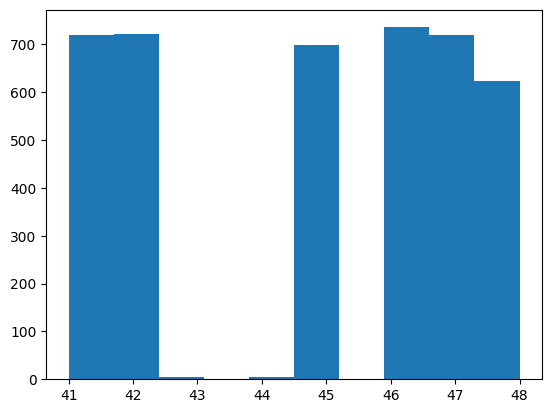

In [9]:
plt.hist([len(i) for i in df_['motif_seq']])

In [12]:
df_.to_pickle(r"C:\Users\Parv\Doc\HelixWorks\Basecalling\code\motifcaller\data\synthetic\pickled_datasets\filtered_length.pkl")